In [538]:
import warnings
warnings.filterwarnings('ignore')

In [539]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [540]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [541]:
df = pd.read_csv("/data/BreadBasket_DMS.csv")
df.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [542]:
df = df.query("Item!='NONE'")

In [543]:
df.info()
df["Qty"]=1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         20507 non-null  object
 1   Time         20507 non-null  object
 2   Transaction  20507 non-null  int64 
 3   Item         20507 non-null  object
dtypes: int64(1), object(3)
memory usage: 801.1+ KB


In [544]:
daily_items = df.groupby(["Date","Item"])["Qty"].sum().reset_index()

In [545]:
#Filtering Top 3 product
top_items = daily_items.groupby("Item")["Qty"].sum().sort_values(ascending=False)[0:3].index
top_items

Index(['Coffee', 'Bread', 'Tea'], dtype='object', name='Item')

In [546]:
top_daily_items = daily_items[daily_items["Item"].isin(top_items)]
top_daily_items

,Date,Item,Qty
1,2016-10-30,Bread,29
4,2016-10-30,Coffee,33
24,2016-10-30,Tea,12
26,2016-10-31,Bread,24
28,2016-10-31,Coffee,60
...,...,...,...
3612,2017-04-08,Coffee,41
3633,2017-04-08,Tea,9
3639,2017-04-09,Bread,9
3642,2017-04-09,Coffee,17


In [547]:
top_daily_items = top_daily_items.sort_values(by=["Item","Date"])
top_daily_items

,Date,Item,Qty
1,2016-10-30,Bread,29
26,2016-10-31,Bread,24
50,2016-11-01,Bread,21
73,2016-11-02,Bread,17
95,2016-11-03,Bread,26
...,...,...,...
3554,2017-04-05,Tea,14
3578,2017-04-06,Tea,11
3599,2017-04-07,Tea,6
3633,2017-04-08,Tea,9


In [548]:
top_daily_items["Date"] = pd.to_datetime(top_daily_items["Date"])
top_daily_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 1 to 3658
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    475 non-null    datetime64[ns]
 1   Item    475 non-null    object        
 2   Qty     475 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.8+ KB


In [549]:
df_coffee = top_daily_items[top_daily_items['Item'] == "Coffee"]
df_tea = top_daily_items[top_daily_items['Item'] == "Tea"]
df_bread = top_daily_items[top_daily_items['Item'] == "Bread"]

In [550]:
df_coffee.shape, df_tea.shape, df_bread.shape

((158, 3), (158, 3), (159, 3))

In [551]:
df_coffee = df_coffee[['Date','Qty']]
df_tea = df_tea[['Date','Qty']]
df_bread = df_bread[['Date','Qty']]

In [552]:
df_coffee.set_index('Date', inplace=True)
df_tea.set_index('Date', inplace=True)
df_bread.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

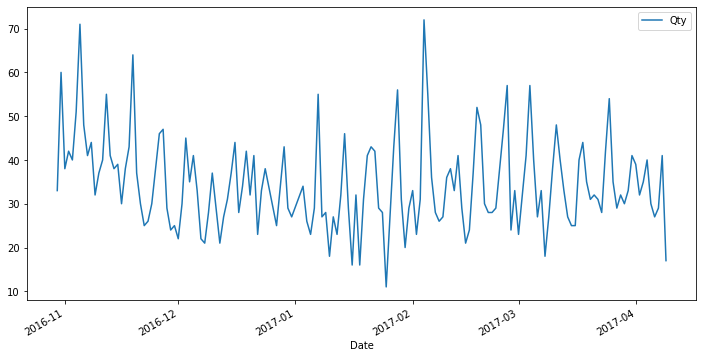

In [553]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
df_coffee.plot()

In [554]:
Qty_result=adfuller(df_coffee['Qty'])

In [555]:
Qty_result

(-3.231959639429196,
 0.018207677607260886,
 13,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 997.5022046747692)

In [556]:
def adfuller_test(Qty, item):
    result=adfuller(Qty)
    print ("Item: ", item)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [557]:
adfuller_test(df_coffee['Qty'], "Coffee")

Item:  Coffee
ADF Test Statistic : -3.231959639429196
p-value : 0.018207677607260886
#Lags Used : 13
Number of Observations : 144
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [558]:
adfuller_test(df_tea['Qty'], "Tea")

Item:  Tea
ADF Test Statistic : -3.900603409702
p-value : 0.002030410828295478
#Lags Used : 6
Number of Observations : 151
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [559]:
adfuller_test(df_bread['Qty'], "Bread")

Item:  Bread
ADF Test Statistic : -3.1713572839272346
p-value : 0.02170365726149992
#Lags Used : 6
Number of Observations : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [560]:
df_coffee['First_Difference'] = df_coffee['Qty'] - df_coffee['Qty'].shift(1)
df_tea['First_Difference'] = df_tea['Qty'] - df_tea['Qty'].shift(1)
df_bread['First_Difference'] = df_bread['Qty'] - df_bread['Qty'].shift(1)

In [561]:
adfuller_test(df_coffee['First_Difference'].dropna(), "Coffee")

Item:  Coffee
ADF Test Statistic : -5.909174996431334
p-value : 2.6639376308000976e-07
#Lags Used : 12
Number of Observations : 144
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [562]:
adfuller_test(df_tea['First_Difference'].dropna(), "Tea")

Item:  Tea
ADF Test Statistic : -11.434830085861137
p-value : 6.385539541160188e-21
#Lags Used : 5
Number of Observations : 151
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [563]:
adfuller_test(df_bread['First_Difference'].dropna(), "Bread")

Item:  Bread
ADF Test Statistic : -14.503697927308039
p-value : 5.8758825347541035e-27
#Lags Used : 5
Number of Observations : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


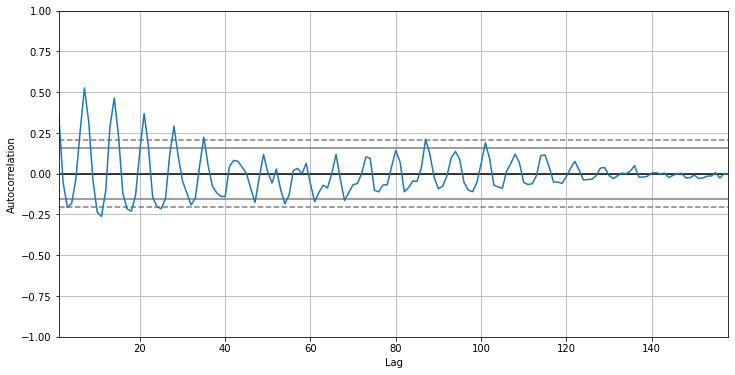

In [564]:
autocorrelation_plot(df_coffee['Qty'])
plt.show()

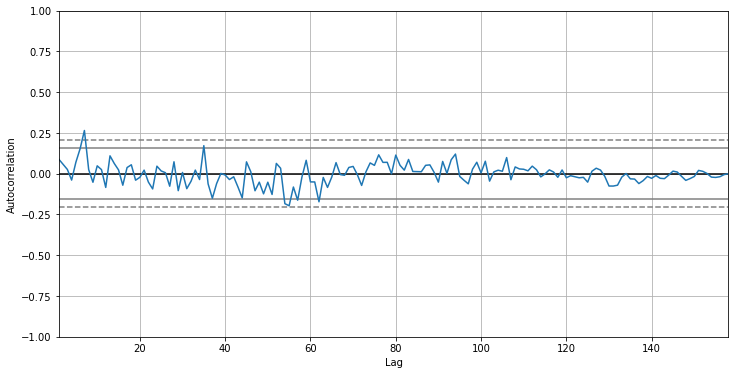

In [565]:
autocorrelation_plot(df_tea['Qty'])
plt.show()

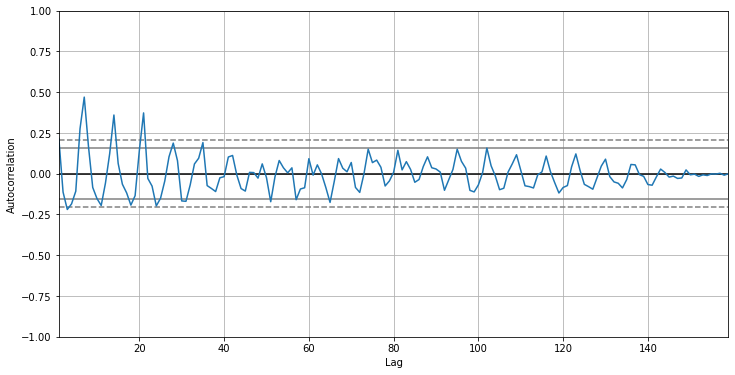

In [566]:
autocorrelation_plot(df_bread['Qty'])
plt.show()

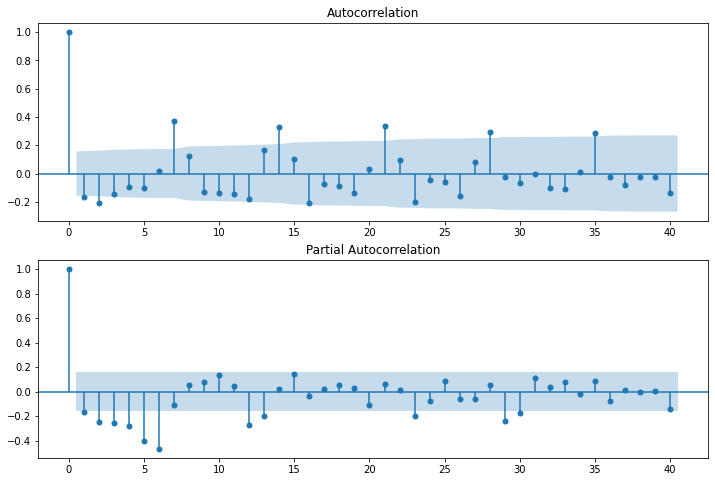

In [567]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_coffee['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_coffee['First_Difference'].dropna(),lags=40,ax=ax2)

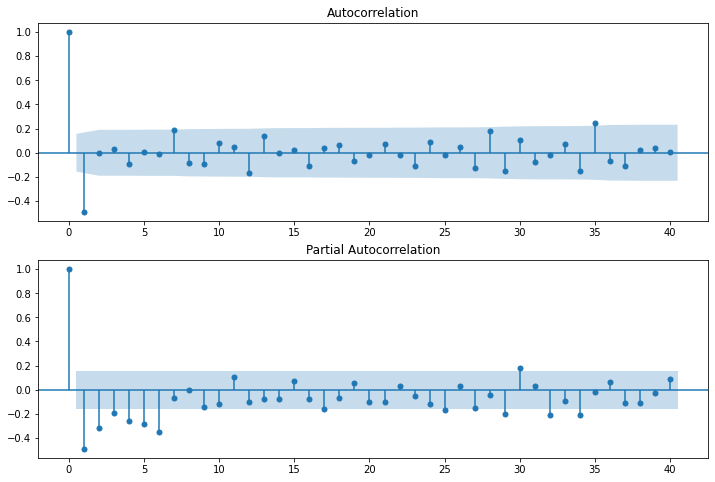

In [568]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_tea['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_tea['First_Difference'].dropna(),lags=40,ax=ax2)

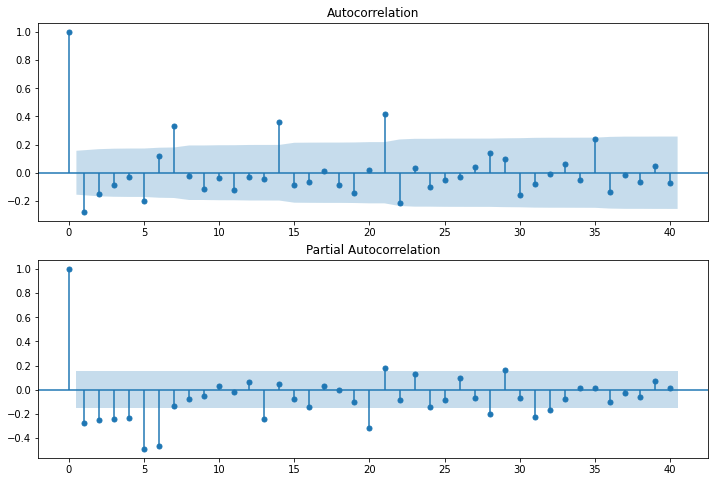

In [569]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_bread['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_bread['First_Difference'].dropna(),lags=40,ax=ax2)

In [570]:
model=ARIMA(df_coffee['Qty'],order=(1,1,0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.Qty   No. Observations:                  157
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -607.299
Method:                       css-mle   S.D. of innovations             11.578
Date:                Wed, 18 Jan 2023   AIC                           1220.597
Time:                        16:24:35   BIC                           1229.766
Sample:                             1   HQIC                          1224.321
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1050      0.787     -0.133      0.894      -1.648       1.438
ar.L1.D.Qty    -0.1748      0.081     -2.162      0.031      -0.333      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.7224           +0.0000j            5.7224            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

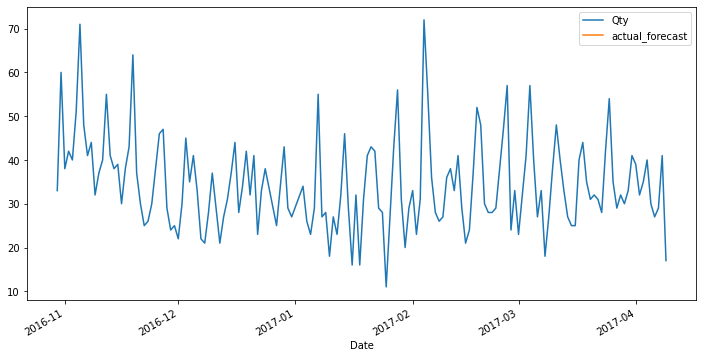

In [571]:
df_coffee['test_prediction'] = float("nan")
df_coffee['actual_forecast'] = float("nan")
df_coffee.iloc[151:,2]=model_fit.predict(start=151,end=157,dynamic=True)
df_coffee[['Qty','actual_forecast']].plot(figsize=(12,6))

<AxesSubplot:xlabel='Date'>

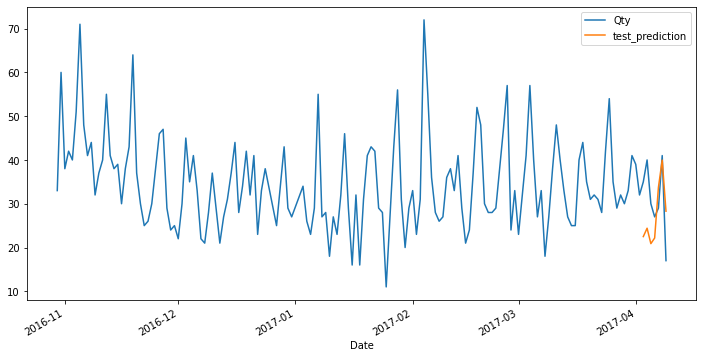

In [582]:
model=sm.tsa.statespace.SARIMAX(df_coffee['Qty'],order=(1, 1, 0),seasonal_order=(1,1,1,7))
results=model.fit()
df_coffee.iloc[151:, 2]=results.predict(start=151,end=157,dynamic=True)
df_coffee[['Qty','test_prediction']].plot(figsize=(12,6))

<AxesSubplot:xlabel='Date'>

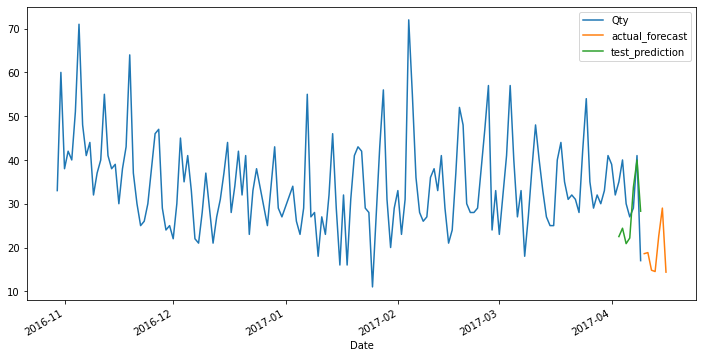

In [573]:
future_dates=[df_coffee.index[-1]+ DateOffset(days=x)for x in range(1,8)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_coffee.columns)
future_df=pd.concat([df_coffee,future_datest_df])
future_df.index.name = 'Date'
future_df.reset_index(inplace=True)
future_df.iloc[158:,4] = results.predict(start = 158, end = 164, dynamic= True)
future_df.set_index('Date',inplace=True)
#print(future_df.tail(14))
future_df[['Qty', 'actual_forecast','test_prediction']].plot(figsize=(12, 6))

In [591]:
coffee_prediction = dict(future_df.iloc[-7:,3])

In [605]:
coffee_prediction

{Timestamp('2017-04-10 00:00:00'): 6.607704267465087,
 Timestamp('2017-04-11 00:00:00'): 6.631655213242649,
 Timestamp('2017-04-12 00:00:00'): 8.342055866890842,
 Timestamp('2017-04-13 00:00:00'): 5.757384028558794,
 Timestamp('2017-04-14 00:00:00'): 6.473475802205327,
 Timestamp('2017-04-15 00:00:00'): 8.542818150618963,
 Timestamp('2017-04-16 00:00:00'): 5.10770158927305}

<AxesSubplot:xlabel='Date'>

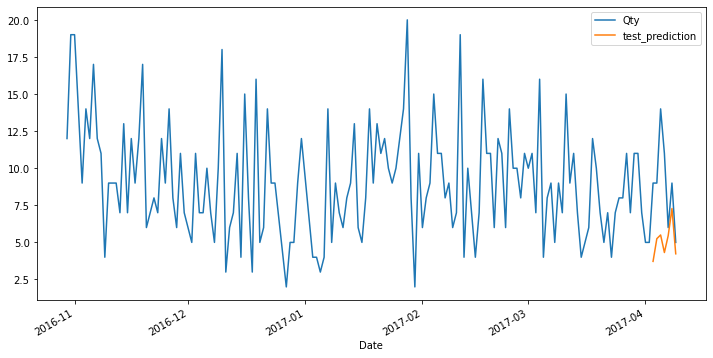

In [602]:
df_tea['test_prediction'] = float("nan")
df_tea['actual_forecast'] = float("nan")

model=sm.tsa.statespace.SARIMAX(df_tea['Qty'],order=(1, 2, 0),seasonal_order=(1,1,1,7))
results=model.fit()
df_tea.iloc[151:, 2]=results.predict(start=151,end=157,dynamic=True)
df_tea[['Qty','test_prediction']].plot(figsize=(12,6))

<AxesSubplot:xlabel='Date'>

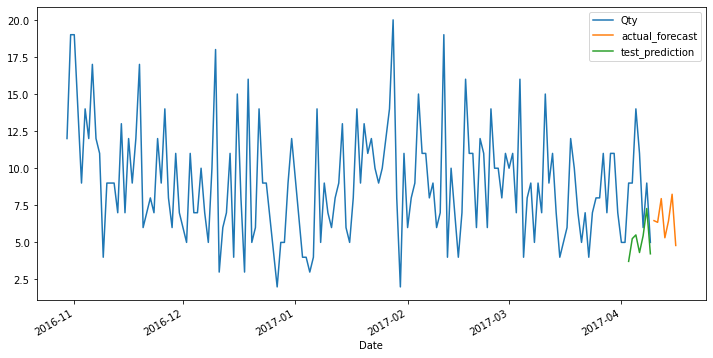

In [603]:
future_dates=[df_tea.index[-1]+ DateOffset(days=x)for x in range(1,8)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_tea.columns)
future_df=pd.concat([df_tea,future_datest_df])
future_df.index.name = 'Date'
future_df.reset_index(inplace=True)
future_df.iloc[158:,4] = results.predict(start = 158, end = 164, dynamic= True)
future_df.set_index('Date',inplace=True)
#print(future_df.tail(14))
future_df[['Qty', 'actual_forecast','test_prediction']].plot(figsize=(12, 6))

In [604]:
tea_prediction = dict(future_df.iloc[-7:,3])
tea_prediction

{Timestamp('2017-04-10 00:00:00'): 6.466345216811705,
 Timestamp('2017-04-11 00:00:00'): 6.353109697606636,
 Timestamp('2017-04-12 00:00:00'): 7.951175893167642,
 Timestamp('2017-04-13 00:00:00'): 5.3129433303933045,
 Timestamp('2017-04-14 00:00:00'): 6.443001755062346,
 Timestamp('2017-04-15 00:00:00'): 8.246057788773738,
 Timestamp('2017-04-16 00:00:00'): 4.793579336551096}

<AxesSubplot:xlabel='Date'>

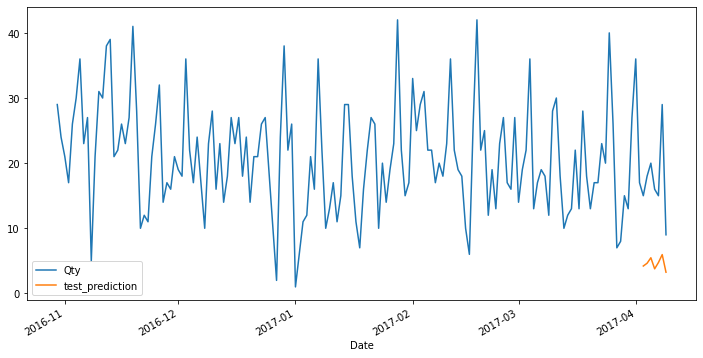

In [622]:
df_bread['test_prediction'] = float("nan")
df_bread['actual_forecast'] = float("nan")

model=sm.tsa.statespace.SARIMAX(df_tea['Qty'],order=(1, 2, 1),seasonal_order=(1,1,1,7))
results=model.fit()
df_bread.iloc[151:, 2]=results.predict(start=151,end=157,dynamic=True)
df_bread[['Qty','test_prediction']].plot(figsize=(12,6))

<AxesSubplot:xlabel='Date'>

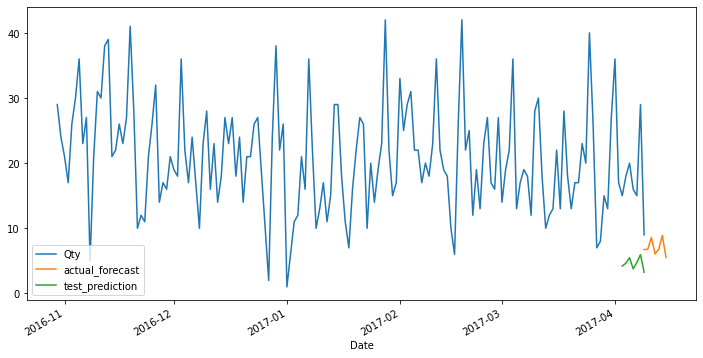

In [623]:
future_dates=[df_bread.index[-1]+ DateOffset(days=x)for x in range(1,8)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_bread.columns)
future_df=pd.concat([df_bread,future_datest_df])
future_df.index.name = 'Date'
future_df.reset_index(inplace=True)
future_df.iloc[158:,4] = results.predict(start = 158, end = 164, dynamic= True)
future_df.set_index('Date',inplace=True)
#print(future_df.tail(14))
future_df[['Qty', 'actual_forecast','test_prediction']].plot(figsize=(12, 6))

In [624]:
tea_prediction = dict(future_df.iloc[-7:,3])
tea_prediction

{Timestamp('2017-04-10 00:00:00'): 6.786157035234015,
 Timestamp('2017-04-11 00:00:00'): 8.592076160133502,
 Timestamp('2017-04-12 00:00:00'): 6.053984333402367,
 Timestamp('2017-04-13 00:00:00'): 6.779661604526812,
 Timestamp('2017-04-14 00:00:00'): 8.913337818582,
 Timestamp('2017-04-15 00:00:00'): 5.53053650108872,
 Timestamp('2017-04-16 00:00:00'): nan}

In [ ]:
def score(model, request):
    payload = request.json["payload"]
    data = pd.DataFrame(eval(payload))
    prediction = pd.Series(model.predict(data))[0]
    return "No failure" if prediction == 0 else "Failure"